# Taller Deep Learning Obligatorio

## Participantes
* Martin Martinez: 344567
* Rodrigo Paz: 325277



In [1]:
# Importamos todas las dependencias
from matplotlib import pyplot as plt
import os
from pathlib import Path
from SegmentationDataset import SegmentacionDataset
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import v2 as T
from typing import Callable, Optional
import numpy as np
from UNet import UNet
from utils import (
    train,
    plot_taining,
    model_classification_report
)


/opt/anaconda3/envs/pytorch_m1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Fijamos la semilla para que los resultados sean reproducibles
SEED = 34
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
#Declaramos todas las variables globales y los hiper parametros del modelo
DEVICE = "cpu"
if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.backends.mps.is_available():
    DEVICE = "mps"

NUM_WORKERS = 0 if DEVICE == "mps" else max(os.cpu_count() - 1, 1)  #número de workers para cargar los datos a menos que estemos corriendo en Mac OS
BATCH_SIZE = 2  # tamaño del batch

# DEVICE = "cpu"

print(f"Device: {DEVICE}")
print(f"Num Workers: {NUM_WORKERS}")

Device: mps
Num Workers: 0


### Dataset
Los datos provistos en la competencia de Kaggel, para cada muestra se tiene la imagen en formato PNG, en un tamaño fijo 800x800 y por separado tenemos en otra carpeta el resultado esperado de esta muestra. Crearemos un Dataset propio para cargar los X, Y

In [4]:


# TRAIN_DATA_DIR = Path('tdl-segmentacion/train')
TRAIN_DATA_DIR = Path('small-segmentation/train')
IMAGE_SIZE = (800, 800) #Dimensiones de la imagen tiene que ser multiplos de 8


def create_train_val_datasets(
    validation_percentage: float = 0.2,
    x_transform: Optional[Callable] = None,
    y_transform: Optional[Callable] = None,
):
    full_train_dataset = SegmentacionDataset(
        root_dir = TRAIN_DATA_DIR,
        load_mask = True,
        x_transform = x_transform,
        y_transform = y_transform 
    )
    return random_split(
        full_train_dataset,
        [1 - validation_percentage, validation_percentage],
        generator = torch.Generator().manual_seed(SEED)
    )

x_transform = [
    T.Resize(IMAGE_SIZE),
    T.ToImage(),
    T.ToDtype(torch.float32)
]

y_transform = [
    T.Resize(IMAGE_SIZE),
    T.ToImage(),
    T.ToDtype(torch.float32)
]


test_dataset, _ = create_train_val_datasets(
    x_transform =  T.Compose(x_transform),
    y_transform = T.Compose(y_transform)
)

test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
    )


images, masks = next(iter(test_loader))
image = images[0]
mask = masks[0]

print(f'{type(image)=},{type(mask)=}')
print(f'{image.shape=},{mask.shape=}')


type(image)=<class 'torch.Tensor'>,type(mask)=<class 'torch.Tensor'>
image.shape=torch.Size([3, 800, 800]),mask.shape=torch.Size([1, 800, 800])


In [5]:
print(f'image cantidad de unos:{(image == 1 ).sum().item()}')
print(f'image cantidad de ceros:{(image == 0).sum().item()}')
print(f'image Cantidad de valores que no son cero ni uno:{((image > 0) & (image < 1)).sum().item()}')
print(f'image Cantidad de valores menores que cero:{(image < 0).sum().item()}')
print(f'image Cantidad de valores mayores que 1:{(image > 1).sum().item()}')
print(f'image Valores unicos :{ image.unique()}')

print(f'mask cantidad de unos:{(mask == 1 ).sum().item()}')
print(f'mask cantidad de ceros:{(mask == 0).sum().item()}')
print(f'mask Cantidad de valores que no son cero ni uno:{((mask > 0) & (mask < 1)).sum().item()}')
print(f'mask Cantidad de valores menores que cero:{(mask < 0).sum().item()}')
print(f'mask Cantidad de valores mayores que 1:{(mask > 1).sum().item()}')
print(f'mask Valores unicos :{ mask.unique()}')

image cantidad de unos:71086
image cantidad de ceros:60389
image Cantidad de valores que no son cero ni uno:0
image Cantidad de valores menores que cero:0
image Cantidad de valores mayores que 1:1788525
image Valores unicos :tensor([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
         12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
         24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
         36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
         48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,
         60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
         72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,
         84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,
         96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106., 107.,
        108., 109., 110., 111., 112., 113., 114., 115.,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


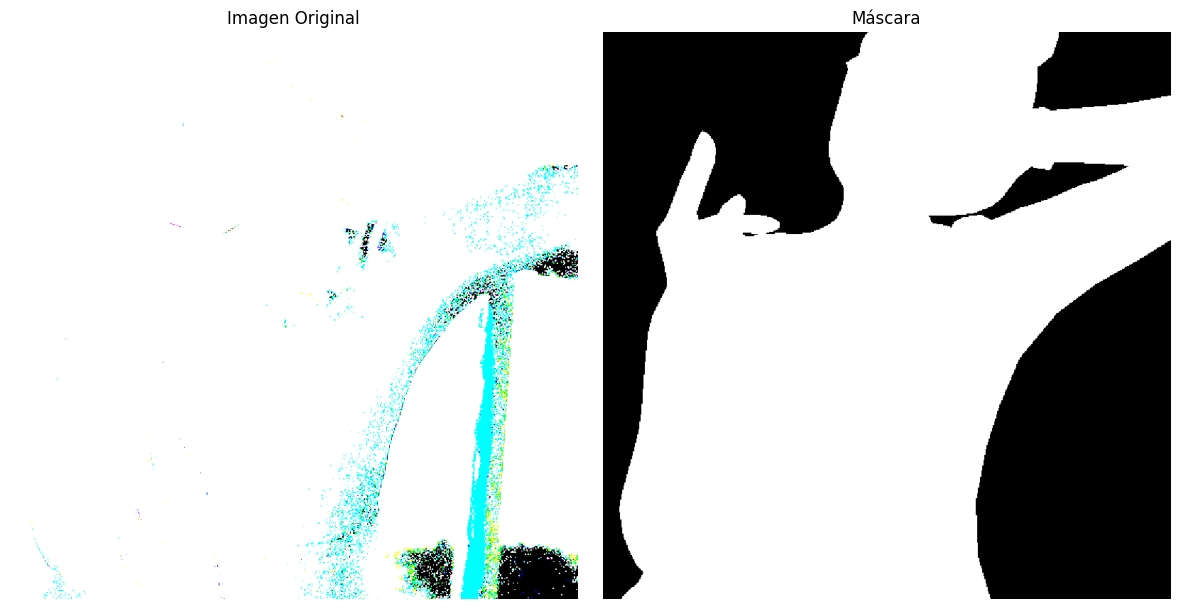

In [6]:
# Creamos una funcion que nos muestre la imagen original y su mascara

def plot_image_with_mask(
    image,
    mask
):
    """
    Muestra la imagen original y a su lado su respectiva mascara. Se asume que tanto la imagen y la mascara tienen el mismo tamaño
    """
    image_np = image.permute(1, 2, 0).numpy()
    mask_np = mask.squeeze(0).numpy()
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    # Mostrar la imagen original
    axs[0].imshow(image_np)
    axs[0].set_title("Imagen Original")
    axs[0].axis('off')
    axs[1].imshow(mask_np, cmap='gray')
    axs[1].set_title("Máscara")
    axs[1].axis('off')
    plt.tight_layout()
    plt.show()

plot_image_with_mask(image, mask)

### Generamos el modelo de U-Net

In [7]:
model = UNet(input_channel=3, out_channel=1, layer_channels=[64, 128, 256, 512, 1024]).to(DEVICE)
BATCH_SIZE = 1
summary(model, input_size=(BATCH_SIZE, 3, *IMAGE_SIZE))

layers_pairs=[(1024, 512), (512, 256), (256, 128), (128, 64), (64, 64)]


Layer (type:depth-idx)                                       Output Shape              Param #
UNet                                                         [1, 1, 800, 800]          --
├─UNetLayer: 1-1                                             [1, 1, 800, 800]          --
│    └─UNetNode: 2-1                                         [1, 64, 800, 800]         --
│    │    └─Conv2d: 3-1                                      [1, 64, 800, 800]         1,792
│    │    └─BatchNorm2d: 3-2                                 [1, 64, 800, 800]         128
│    │    └─Conv2d: 3-3                                      [1, 64, 800, 800]         36,928
│    │    └─BatchNorm2d: 3-4                                 [1, 64, 800, 800]         128
│    │    └─MaxPool2d: 3-5                                   [1, 64, 400, 400]         --
│    └─UNetLayer: 2-2                                        [1, 64, 800, 800]         --
│    │    └─UNetNode: 3-6                                    [1, 128, 400, 400]       

In [14]:
CRITERION = nn.BCELoss().to(DEVICE)

def log(epoch, train_loss, val_loss):
    print({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss})

train_dataset, val_dataset = create_train_val_datasets(
    x_transform =  T.Compose(x_transform),
    y_transform = T.Compose(y_transform)
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
)

model = UNet(input_channel=3, out_channel=1, layer_channels=[64, 128, 256, 512, 1024]).to(DEVICE)

train_errors_ln_da, val_errors_ln_da = train(
    model = model,
    optimizer = optim.Adam(model.parameters(), lr=0.0001),
    criterion = CRITERION,
    train_loader = train_loader,
    val_loader = val_loader,
    device = DEVICE,
    do_early_stopping = True,
    patience = 5,
    epochs = 30,
    log_fn = log,
    log_every=1
)

layers_pairs=[(1024, 512), (512, 256), (256, 128), (128, 64), (64, 64)]
{'epoch': 0, 'train_loss': 0.6877604325612386, 'val_loss': 0.6637248992919922}
{'epoch': 1, 'train_loss': 0.622675210237503, 'val_loss': 0.6624369025230408}
{'epoch': 2, 'train_loss': 0.5842158148686091, 'val_loss': 0.6534397006034851}
{'epoch': 3, 'train_loss': 0.5515904823939005, 'val_loss': 0.6225540041923523}
{'epoch': 4, 'train_loss': 0.5059990435838699, 'val_loss': 0.6279610395431519}
{'epoch': 5, 'train_loss': 0.49155741433302563, 'val_loss': 0.5490937232971191}
{'epoch': 6, 'train_loss': 0.47656290729840595, 'val_loss': 0.4902535080909729}
{'epoch': 7, 'train_loss': 0.45596402883529663, 'val_loss': 1.069184422492981}
{'epoch': 8, 'train_loss': 0.43815062940120697, 'val_loss': 0.4856906235218048}
{'epoch': 9, 'train_loss': 0.4199773818254471, 'val_loss': 3.312832832336426}
{'epoch': 10, 'train_loss': 0.419028880695502, 'val_loss': 0.31829458475112915}
{'epoch': 11, 'train_loss': 0.3853376681605975, 'val_loss

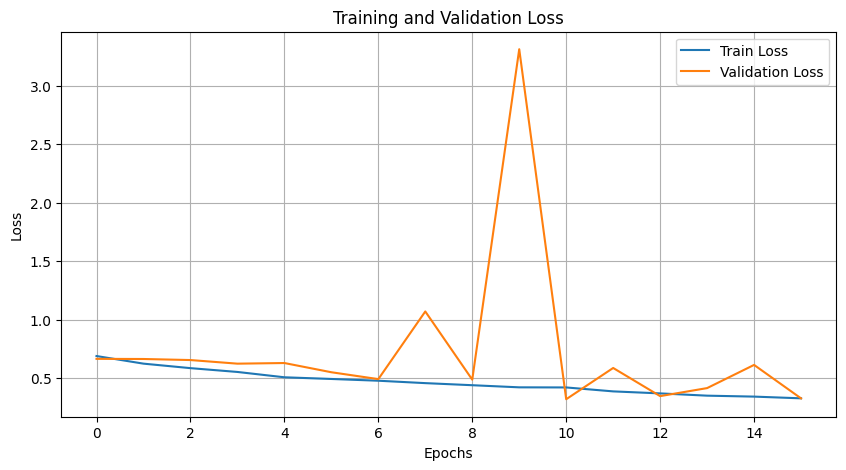

In [15]:
plot_taining(train_errors_ln_da, val_errors_ln_da)

# (accuracy, f1_score, precision, recall) = model_classification_report(model, val_loader, DEVICE, 1)
# print(f'Classification Report:')
# print(f'{accuracy = }')
# print(f'{f1_score = }')
# print(f'{precision = }')
# print(f'{recall = }')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


image.shape=torch.Size([3, 800, 800]),real_mask.shape=torch.Size([1, 800, 800])
cantidad de unos en real_mask:142119


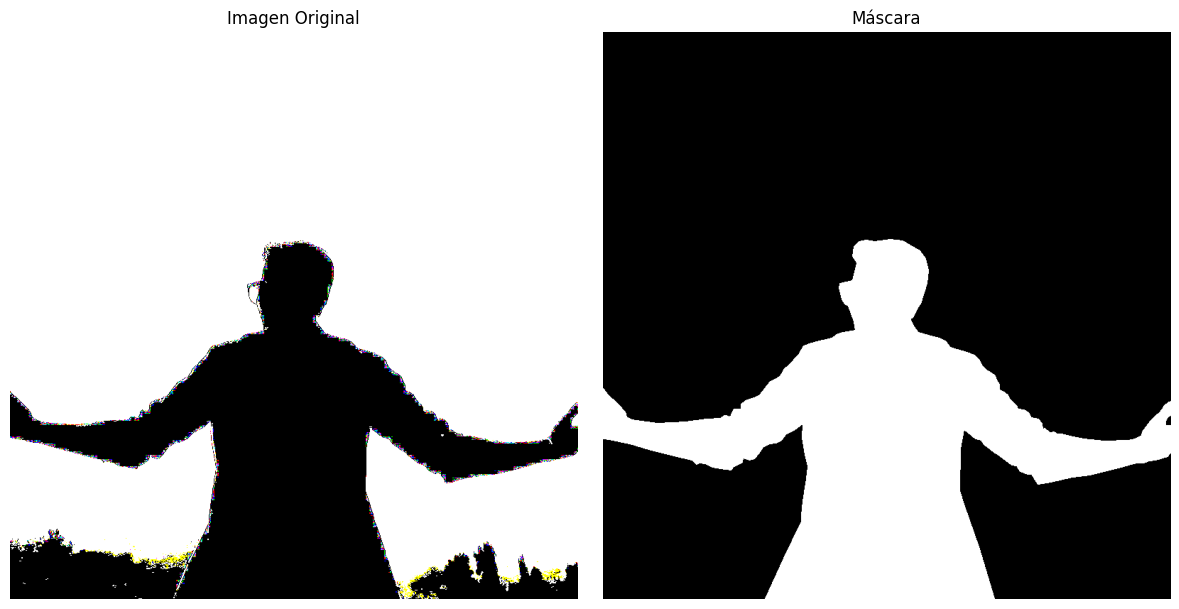

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


tensor([[[0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]]])
image.shape=torch.Size([3, 800, 800]),predicted_mask.shape=torch.Size([1, 800, 800])
cantidad de unos:166550
cantidad de ceros:473450
delta=4.008281230926514


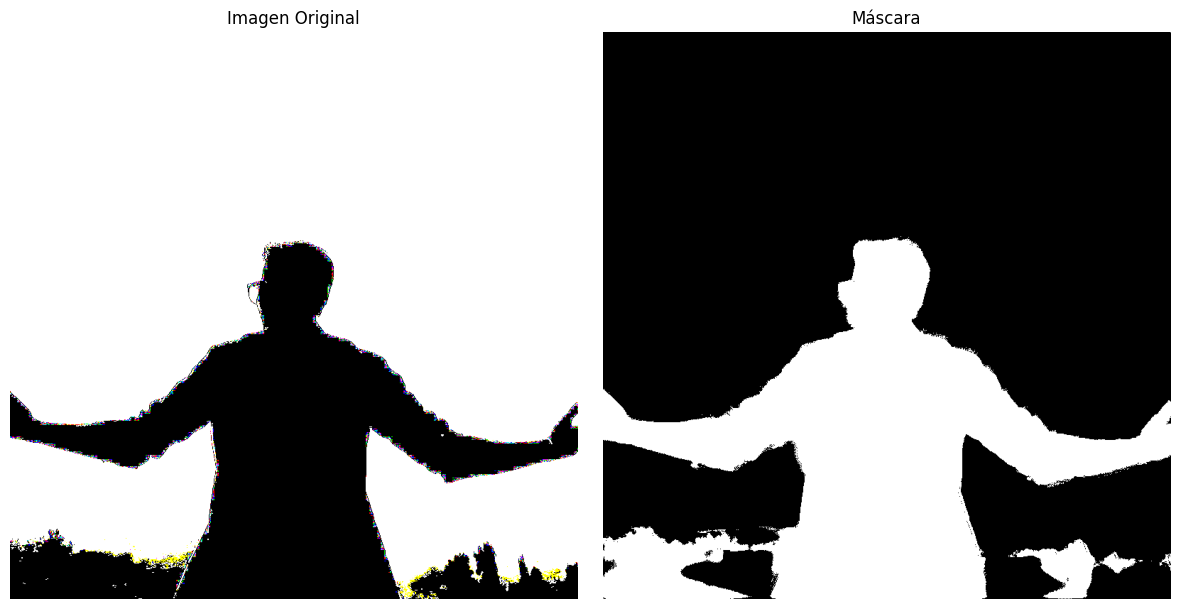

In [16]:
#Comprobamos el modelo a ver como entrenó con una imagen y vemos su salida
images, masks = next(iter(train_loader))
image = images[0]
real_mask = masks[0]
print(f'{image.shape=},{real_mask.shape=}')
print(f'cantidad de unos en real_mask:{(real_mask > 0).sum().item()}')
# print(real_mask)
plot_image_with_mask(image, real_mask)
model.eval()
with torch.no_grad():
    predicted_mask = model(image.unsqueeze(0).to(DEVICE))
    predicted_mask = predicted_mask.squeeze(0).cpu()
    predicted_mask = (predicted_mask >= 0.5).float()
    print(predicted_mask)
print(f'{image.shape=},{predicted_mask.shape=}')
print(f'cantidad de unos:{(predicted_mask == 1 ).sum().item()}')
print(f'cantidad de ceros:{(predicted_mask == 0 ).sum().item()}')
delta = CRITERION(real_mask, predicted_mask).item()
print(f'{delta=}')
plot_image_with_mask(image, predicted_mask)


In [11]:
from PIL import Image
import torch
from torchvision.transforms import v2 as T

class ToLongTensor:
    def __call__(self, img):
        # return transforms.ToTensor()(img)
        # Convertir la imagen de PIL a tensor de float y luego cambiar tipo a long
        tensor = T.ToTensor()(img) * 255  # Multiplicamos por 255 para recuperar valores 0-255
        return tensor.to(torch.long)

image = Image.open('small-segmentation/train/masks/2.png').convert('L')
transform = T.Compose([ToLongTensor()])
tensor = transform(image)

print(tensor.shape, tensor.dtype)  # Verifica el tamaño y tipo del tensor
tensor.unique()  # Verifica los valores únicos del tensor

torch.Size([1, 800, 800]) torch.int64


/opt/anaconda3/envs/pytorch_m1/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


tensor([0, 1])